In [50]:
import pandas as pd
import numpy as np
import geopandas as gpd
import datetime, calendar

## Cook County Assessor's Residential Sales Data

In [51]:
query = ("""https://datacatalog.cookcountyil.gov/resource/5pge-nu6u.json?$limit=1000000\
&$select=pin,sale_price,sale_year,est_land,est_bldg,age,bldg_sf,addr,centroid_x,centroid_y"""
    ).replace('\n','')
    
sales_df = pd.read_json(query)
# filter any sales that are not arms-length transactions (only fair sales)
sales_df = sales_df[sales_df['sale_price'] > 1000]

In [52]:
sales_df.head()

,pin,sale_price,sale_year,est_land,est_bldg,age,addr,centroid_x,centroid_y,bldg_sf
0,17273100931118,53000.0,2015,9180,14870,44,2921 S MICHIGAN AVE,-87.622577,41.840229,NaN
1,18013090421010,80000.0,2018,4500,55890,57,4431 PRESCOTT AVE,-87.818892,41.810405,NaN
2,16094150130000,79000.0,2014,31500,195710,87,5019 W MAYPOLE AVE,-87.751110,41.883993,7435.0
3,12253140491007,90000.0,2013,8610,87950,26,32 CONTI PKWY,-87.817079,41.928035,NaN
4,12111190201042,118000.0,2018,9750,74600,45,5313 N DELPHIA AVE,-87.840859,41.975825,NaN


In [53]:
# def explore_data_null(df):
#     fig, ax = plt.subplots(figsize=(17,10))
#     sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
#     plt.show()

# explore_data_null(sales_df)

## Merge Chicago neighborhood shapefile

In [54]:
nbs_gdf = gpd.read_file('../data/Boundaries - Neighborhoods.geojson')
nbs_gdf.head(3)

# convert sales dataframe to geopandas dataframe
from shapely.geometry import Point
sales_df = sales_df.dropna(subset=['centroid_x', 'centroid_y'])
geom = [Point(xy) for xy in zip(sales_df['centroid_x'], sales_df['centroid_y'])]
sales_gdf = gpd.GeoDataFrame(sales_df, crs={'init': 'epsg:4326'}, geometry=geom)

# merge sales and neighborhood geopandas dataframes
sales_gdf = gpd.sjoin(sales_gdf, nbs_gdf, how='inner', op='intersects')
sales_gdf.head(3)

# add side based on neighborhood
side_dic = {'Central': ['Loop', 'Near South Side', 'Streeterville', 'West Loop', 'Printers Row',
                         'Gold Coast', 'Rush & Division', 'River North'],
             'North': ['North Center', 'Lake View', 'Lincoln Park', 'Avondale', 'Logan Square', 'Rogers Park', 
                       'West Ridge', 'Uptown', 'Lincoln Square', 'Edison Park', 'Norwood Park', 'Jefferson Park',
                       'Sauganash,Forest Glen', 'North Park', 'Albany Park', "O'Hare", 'Edgewater',
                       'Portage Park', 'Irving Park', 'Dunning', 'Belmont Cragin', 'Hermosa', 'Wrigleyville',
                       'Boystown', 'Andersonville', 'Sheffield & DePaul', 'Bucktown', 'Old Town', 'East Village'],
             'West' : ['Humboldt Park', 'West Loop', 'West Town', 'Austin', 'Garfield Park', 'North Lawndale',
                       'Lower West Side', 'Wicker Park', 'Little Village', 'Little Italy, UIC', 'Greektown',
                       'United Center', 'Montclare', 'Galewood', 'Ukrainian Village'],
             'South': ['Armour Square', 'Douglas', 'Oakland', 'Fuller Park', 'Grand Boulevard', 'Kenwood',
                       'Washington Park', 'Hyde Park', 'Woodlawn', 'South Shore', 'Bridgeport',
                       'Grand Crossing', 'Garfield Ridge', 'Archer Heights', 'Brighton Park', 'Mckinley Park',
                       'New City', 'West Elsdon', 'Gage Park', 'Clearing', 'West Lawn', 'Chicago Lawn',
                       'Englewood', 'Chatham', 'Avalon Park', 'South Chicago', 'Burnside', 'Calumet Heights',
                       "Roseland", 'Pullman', 'South Deering', 'East Side', 'West Pullman', 'Riverdale',
                       'Hegewisch', 'Ashburn', 'Auburn Gresham', 'Beverly', 'Washington Heights',
                       'Mount Greenwood', 'Morgan Park', 'Chinatown']}
new_dic = {}
for k,v in side_dic.items():
    for x in v:
        new_dic[x] = k
sales_gdf['side'] = sales_gdf['pri_neigh'].map(new_dic)

In [55]:
sales_gdf.head()

,pin,sale_price,sale_year,est_land,est_bldg,age,addr,centroid_x,centroid_y,bldg_sf,geometry,index_right,pri_neigh,sec_neigh,shape_area,shape_len,side
0,17273100931118,53000.0,2015,9180,14870,44,2921 S MICHIGAN AVE,-87.622577,41.840229,NaN,POINT (-87.62258 41.84023),31,Douglas,BRONZEVILLE,46004621.137,31027.053671,South
2164,17343220150000,410000.0,2018,96250,237350,130,3819 S WABASH AVE,-87.624368,41.824955,5050.0,POINT (-87.62437 41.82495),31,Douglas,BRONZEVILLE,46004621.137,31027.053671,South
2226,17341030641004,250000.0,2019,22500,186210,11,223 E 31ST ST,-87.620801,41.838154,NaN,POINT (-87.62080 41.83815),31,Douglas,BRONZEVILLE,46004621.137,31027.053671,South
2544,17343101361002,174900.0,2018,17420,109140,12,3552 S GILES AVE,-87.619647,41.829557,NaN,POINT (-87.61965 41.82956),31,Douglas,BRONZEVILLE,46004621.137,31027.053671,South
3271,17334230234016,114218.0,2017,6840,75590,7,3506 S STATE ST,-87.627133,41.830734,NaN,POINT (-87.62713 41.83073),31,Douglas,BRONZEVILLE,46004621.137,31027.053671,South


## *Merge Census data* DE-MERGED
Leaving just `GEO_ID`

In [56]:
import censusdata

# Download Census block boundaries for Chicago
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")

# Load the ACS data with variables
# variables = ["B02001_001E", # Total Population
#              "B02001_002E", # White
#              "B02001_003E", # Black
#              "B19013_001E", # Median Income
#              "GEO_ID"]
variables = ["GEO_ID"]

In [57]:

acs_df = censusdata.download("acs5", 2013, censusdata.censusgeo(
    [("state", "17"), ("county", "031"), ("block group", "*")]), variables)

# Merge ACS data with Census block boundaries 
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: str(x)[:12])
acs_df["geo_12"] = acs_df["GEO_ID"].map(lambda x: str(x)[-12:])
merged_gdf = acs_df.merge(census_gdf, on="geo_12", how="inner")
merged_gdf = gpd.GeoDataFrame(merged_gdf[variables + ["geometry"]].drop_duplicates())

# Merge the dataframe from step 3 with sales geopandas dataframe
sales_gdf = gpd.sjoin(sales_gdf.drop(columns=['index_right']), merged_gdf, how='left')

#     total_pop_year = "{} Total Population".format(year)
#     white_pop_year = "{} White Population".format(year)
#     white_perc_year = "{} Percent White".format(year)
#     black_pop_year = "{} Black Population".format(year)
#     black_perc_year = "{} Percent Black".format(year)
#     med_income_year = "{} Median Income".format(year)

#     # Compute the percentage of each Census block's population that is White and African American/Black.
#     sales_gdf = sales_gdf.rename(columns={"B02001_001E": total_pop_year, "B02001_002E": white_pop_year,
#                                           "B02001_003E": black_pop_year, "B19013_001E": med_income_year})
#     sales_gdf[white_perc_year] = sales_gdf[white_pop_year] / sales_gdf[total_pop_year]
#     sales_gdf[black_perc_year] = sales_gdf[black_pop_year] / sales_gdf[total_pop_year]
#     sales_gdf.loc[sales_gdf[med_income_year]  < 0, med_income_year] = 0


C:\Users\ymeri\Anaconda3\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [58]:
#sales_gdf = merge_census(sales_gdf, 2013)
#sales_gdf = merge_census(sales_gdf, 2018)

In [59]:
sales_gdf.head()

,pin,sale_price,sale_year,est_land,est_bldg,age,addr,centroid_x,centroid_y,bldg_sf,geometry,pri_neigh,sec_neigh,shape_area,shape_len,side,index_right,GEO_ID
0,17273100931118,53000.0,2015,9180,14870,44,2921 S MICHIGAN AVE,-87.622577,41.840229,NaN,POINT (-87.62258 41.84023),Douglas,BRONZEVILLE,46004621.137,31027.053671,South,43100.0,1500000US170318392002
2164,17343220150000,410000.0,2018,96250,237350,130,3819 S WABASH AVE,-87.624368,41.824955,5050.0,POINT (-87.62437 41.82495),Douglas,BRONZEVILLE,46004621.137,31027.053671,South,19548.0,1500000US170313514001
2226,17341030641004,250000.0,2019,22500,186210,11,223 E 31ST ST,-87.620801,41.838154,NaN,POINT (-87.62080 41.83815),Douglas,BRONZEVILLE,46004621.137,31027.053671,South,44579.0,1500000US170318420001
2544,17343101361002,174900.0,2018,17420,109140,12,3552 S GILES AVE,-87.619647,41.829557,NaN,POINT (-87.61965 41.82956),Douglas,BRONZEVILLE,46004621.137,31027.053671,South,43146.0,1500000US170318396002
3271,17334230234016,114218.0,2017,6840,75590,7,3506 S STATE ST,-87.627133,41.830734,NaN,POINT (-87.62713 41.83073),Douglas,BRONZEVILLE,46004621.137,31027.053671,South,19583.0,1500000US170313515002


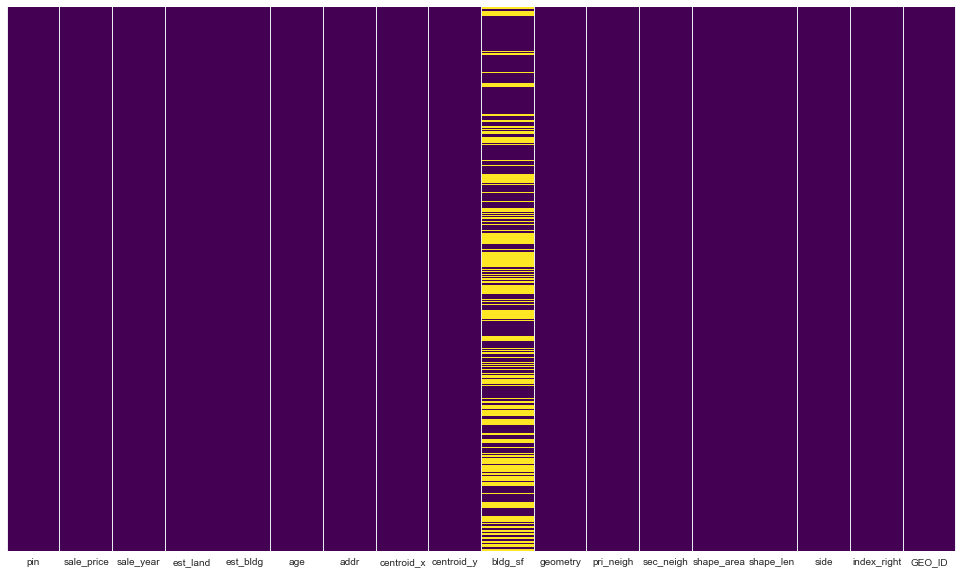

In [60]:
explore_data_null(sales_gdf.sort_values('pri_neigh'))

## Data exploration

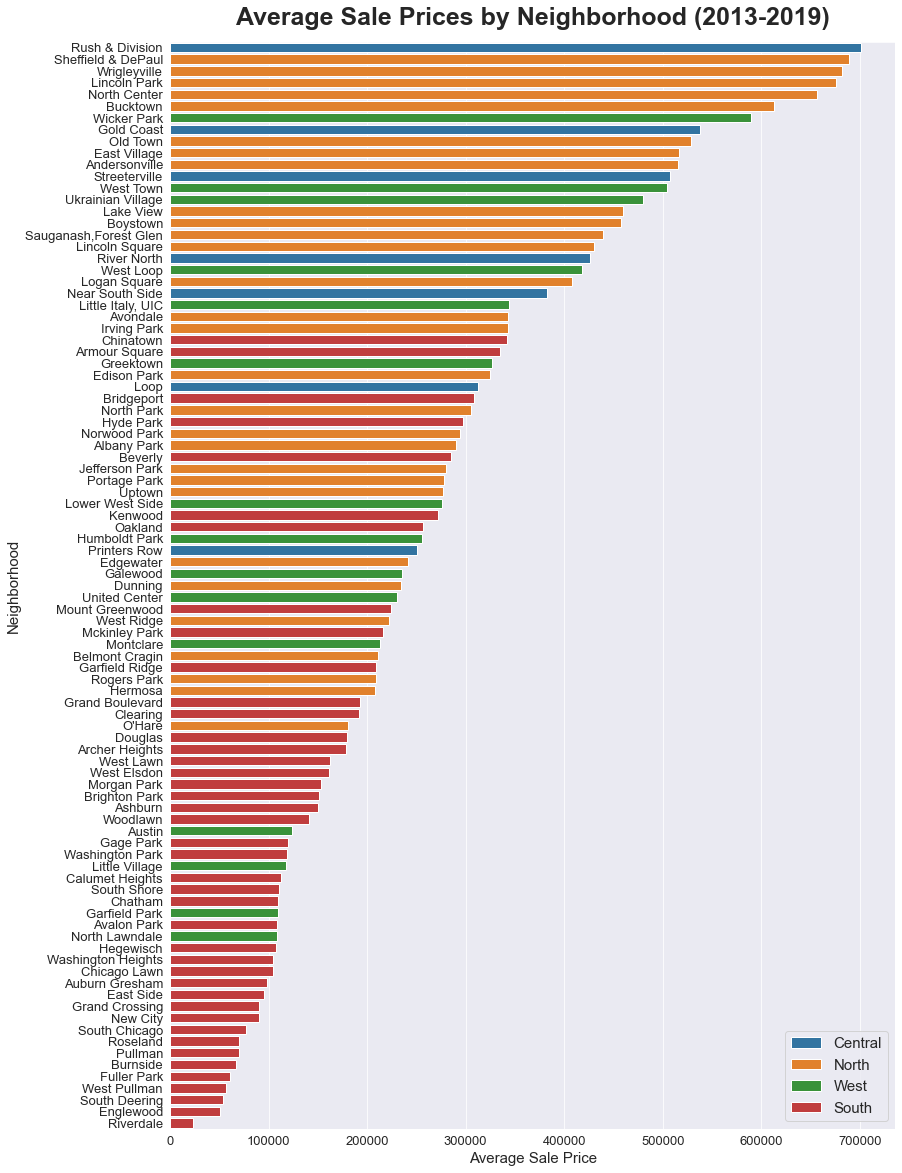

In [61]:
sales_gdf_avgsale = pd.DataFrame(sales_gdf.groupby('pri_neigh')['sale_price'].mean().sort_values(ascending=False)).reset_index()
sales_gdf_avgsale = sales_gdf_avgsale.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')

fig, ax = plt.subplots(figsize=(13,20))

sns.barplot(sales_gdf_avgsale.sale_price, sales_gdf_avgsale.pri_neigh, hue=sales_gdf_avgsale.side, dodge=False)
ax.set_title('Average Sale Prices by Neighborhood (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Average Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

plt.show()

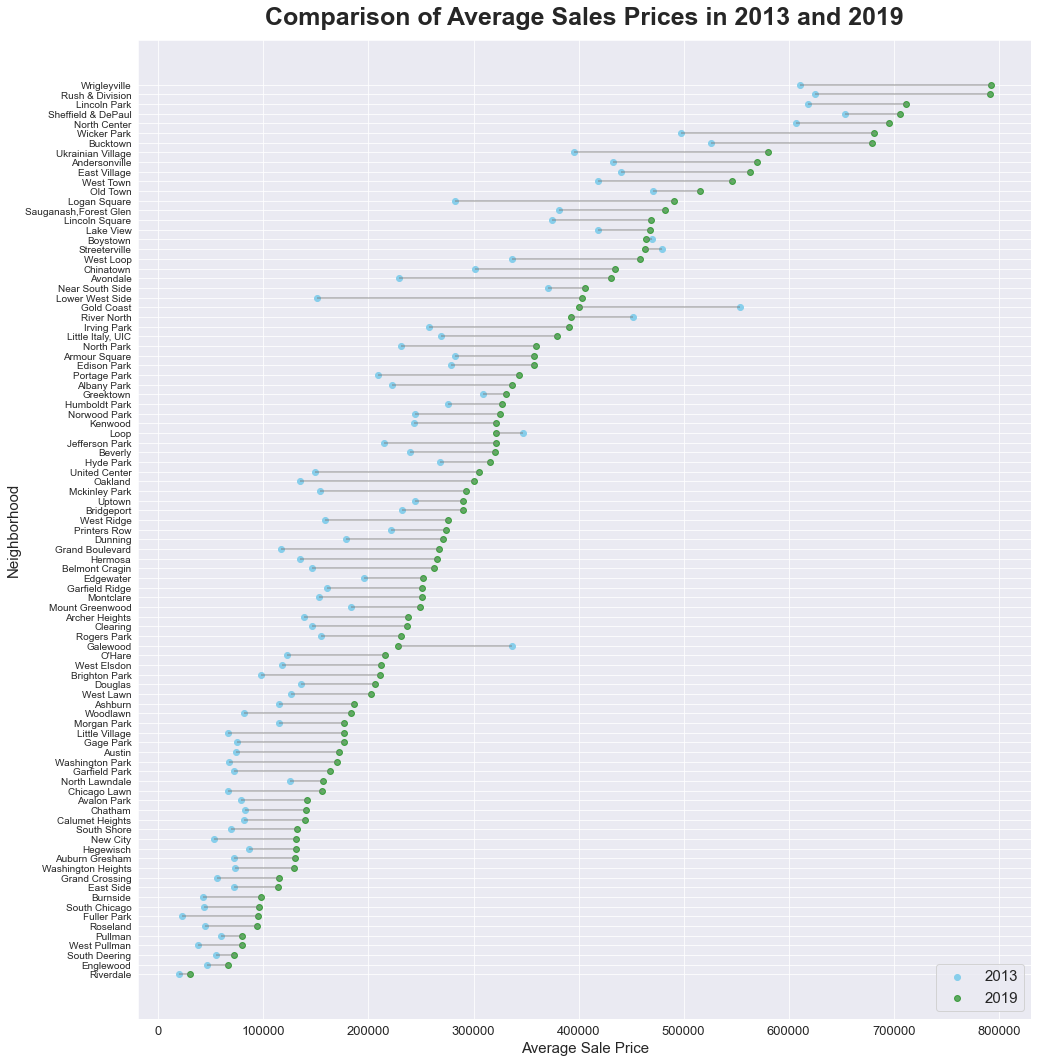

In [62]:
sales_compare = sales_gdf[(sales_gdf['sale_year'] == 2013) | (sales_gdf['sale_year'] == 2019)]
sales_compare = sales_compare.groupby(['pri_neigh', 'sale_year'])['sale_price'].mean().unstack()
sales_compare = sales_compare.sort_values(by=2019, ascending=True)

my_range=range(1,len(sales_compare.index)+1)
 
# The vertical plot is made using the hline function
# I load the seaborn library only to benefit the nice looking feature
fig, ax = plt.subplots(figsize=(16,18))

plt.hlines(y=my_range, xmin=sales_compare[2013], xmax=sales_compare[2019], color='grey', alpha=0.6)
plt.scatter(sales_compare[2013], my_range, color='skyblue', alpha=1, label='2013')
plt.scatter(sales_compare[2019], my_range, color='green', alpha=0.6 , label='2019')
plt.legend()
 
# Add title and axis names
ax.set_title('Comparison of Average Sales Prices in 2013 and 2019', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Average Sale Price', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(my_range, sales_compare.index)
plt.legend(loc='lower right', fontsize=15)

plt.savefig('figures/avg_saleprice.png')
plt.show()

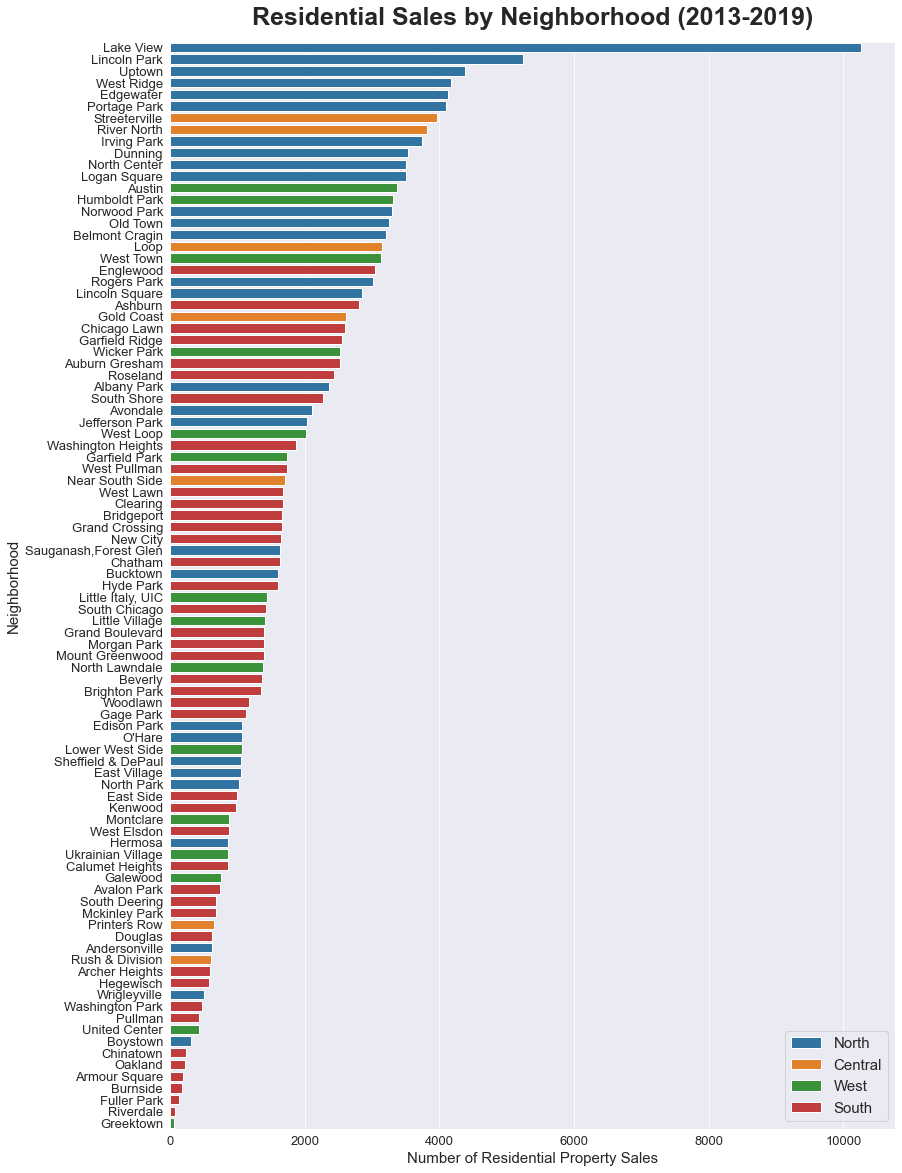

In [63]:
sales_gdf_count = pd.DataFrame(sales_gdf.groupby('pri_neigh')['pin'].nunique().sort_values(ascending=False)).reset_index()
sales_gdf_count = sales_gdf_count.merge(sales_gdf[['pri_neigh', 'side']].drop_duplicates(), on='pri_neigh', how='left')

fig, ax = plt.subplots(figsize=(13,20))

sns.barplot(sales_gdf_count.pin, sales_gdf_count.pri_neigh, hue=sales_gdf_count.side, dodge=False)
ax.set_title('Residential Sales by Neighborhood (2013-2019)', fontsize=25,
             fontweight="bold", loc='center', y=1.01)
ax.set_xlabel('Number of Residential Property Sales', fontsize=15)
ax.set_ylabel('Neighborhood', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='lower right', fontsize=15)

plt.show()

In [150]:
# income_compare = sales_gdf[['pri_neigh', '2013 Median Income', '2018 Median Income']]
# income_compare = income_compare.groupby('pri_neigh')[['2013 Median Income', '2018 Median Income']].mean()
# income_compare = income_compare.sort_values(by='2018 Median Income', ascending=True)

# my_range=range(1,len(income_compare.index)+1)
 
# # The vertical plot is made using the hline function
# fig, ax = plt.subplots(figsize=(13,20))

# plt.hlines(y=my_range, xmin=income_compare['2013 Median Income'], xmax=income_compare['2018 Median Income'], color='grey', alpha=0.6)
# plt.scatter(income_compare['2013 Median Income'], my_range, color='skyblue', alpha=1, label='2013')
# plt.scatter(income_compare['2018 Median Income'], my_range, color='green', alpha=0.6 , label='2019')
# plt.legend()
 
# # Add title and axis names
# ax.set_title('Comparison of Median Income in 2013 and 2018', fontsize=25,
#              fontweight="bold", loc='center', y=1.01)
# ax.set_xlabel('Median Income', fontsize=15)
# ax.set_ylabel('Neighborhood', fontsize=15)
# plt.xticks(fontsize=13)
# plt.yticks(my_range, income_compare.index)
# plt.legend(loc='lower right', fontsize=15)

# plt.show()

In [151]:
sales_gdf.to_csv('data/sales_gdf.csv', index=False)

In [152]:
len(sales_gdf)

218374

In [72]:
final = pd.read_csv("data/Full Data long.csv")

In [73]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218374 entries, 0 to 218373
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   GEO_ID                    218353 non-null  object 
 1   Year                      218374 non-null  int64  
 2   pin                       218374 non-null  int64  
 3   sale_price                218374 non-null  float64
 4   est_land                  218374 non-null  int64  
 5   est_bldg                  218374 non-null  int64  
 6   age                       218374 non-null  int64  
 7   addr                      218371 non-null  object 
 8   bldg_sf                   132602 non-null  float64
 9   geometry                  218374 non-null  object 
 10  pri_neigh                 218374 non-null  object 
 11  sec_neigh                 218374 non-null  object 
 12  side                      218374 non-null  object 
 13  Total Population          186813 non-null  f